In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from sklearn.model_selection import train_test_split
import torch


if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt

# own utils
from utils.graph import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.loss_continous import *
from utils.sampling_tram_data import *



# import ipywidgets as widgets
# from IPython.display import display, clear_output


Train with GPU support.


# 1. Experiments and Paths

In [2]:
experiment_name = "test_modelloader_sampling"   ## <--- set experiment name
seed=42
np.random.seed(seed)

LOG_DIR="/home/bule/TramDag/dev_experiment_logs"
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
DATA_PATH = EXPERIMENT_DIR # <----------- change to different source if needed
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

os.makedirs(EXPERIMENT_DIR,exist_ok=True)
# check if configration dict already exists if not create:

if os.path.exists(CONF_DICT_PATH):
    configuration_dict=load_configuration_dict(CONF_DICT_PATH)
    print(f"Loaded existing configuration from {CONF_DICT_PATH}")
else:
    configuration_dict=create_and_write_new_configuration_dict(experiment_name,CONF_DICT_PATH,EXPERIMENT_DIR,DATA_PATH,LOG_DIR)
    print(f"Created new configuration file at {CONF_DICT_PATH}")

Created new configuration file at /home/bule/TramDag/dev_experiment_logs/test_modelloader_sampling/configuration.json


# 2.  Data

In [3]:
from scipy.special import logit
from mpl_toolkits.mplot3d import Axes3D


# Define the functions used in the DGP
def f1(x1, x2):
    return np.sin(np.pi * x1) * np.cos(np.pi * x2)

def f2(x3, x4):
    return np.exp(-((x3 - 1)**2 + (x4 - 1)**2))

def f3(x5, x6):
    return (x5 * x6) / (1 + x5**2 + x6**2)

def dgp_continuous_interactions(n_obs=1_000, seed=42):
    np.random.seed(seed)

    # Independent variables
    x1 = np.random.uniform(0, 2, size=n_obs)
    x2 = np.random.uniform(0, 2, size=n_obs)
    x3 = np.random.uniform(0, 2, size=n_obs)
    x4 = np.random.uniform(0, 2, size=n_obs)
    x5 = np.random.normal(0, 2, size=n_obs)
    x6 = np.random.uniform(0, 2, size=n_obs)
    x7 = np.random.normal(0, 2, size=n_obs)

    # Response variable with interactions
    y = f1(x1, x2) + f2(x3, x4) + f3(x5, x6) + 1.5 * x7

    df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4, 'x5': x5, 'x6': x6, 'x7': x7, 'x8': y})
    return df


EXP_DATA_PATH=os.path.join(DATA_PATH, f"{experiment_name}.csv")
if not os.path.exists(EXP_DATA_PATH):
    df = dgp_continuous_interactions()

    print(df.head())
    df.to_csv(EXP_DATA_PATH, index=False)
else:
    df = pd.read_csv(EXP_DATA_PATH)
    print(f"Loaded data from {EXP_DATA_PATH}")


data_type= {'x1':'continous','x2':'continous','x3':'continous','x4':'continous','x5':'continous','x6':'continous','x7':'continous','x8':'continous'} # cont:continous, ord:ordinal, oher:everything else than images

write_data_type_to_configuration(data_type, CONF_DICT_PATH)


         x1        x2        x3        x4        x5        x6        x7  \
0  0.749080  0.370266  0.523411  1.345406  2.657282  1.115377  0.006295   
1  1.901429  1.083802  0.493958  1.593363  0.626369  0.109221  2.459981   
2  1.463988  1.745892  1.812509  0.500936 -1.213007  1.943691  1.965366   
3  1.197317  1.464450  0.499092  1.249748  0.911808  1.025230 -2.800141   
4  0.312037  1.613122  0.543899  1.143492 -0.918181  0.581754  1.174525   

         x8  
0  1.316253  
1  4.577286  
2  2.280147  
3 -3.080114  
4  2.601591  
Configuration updated successfully.


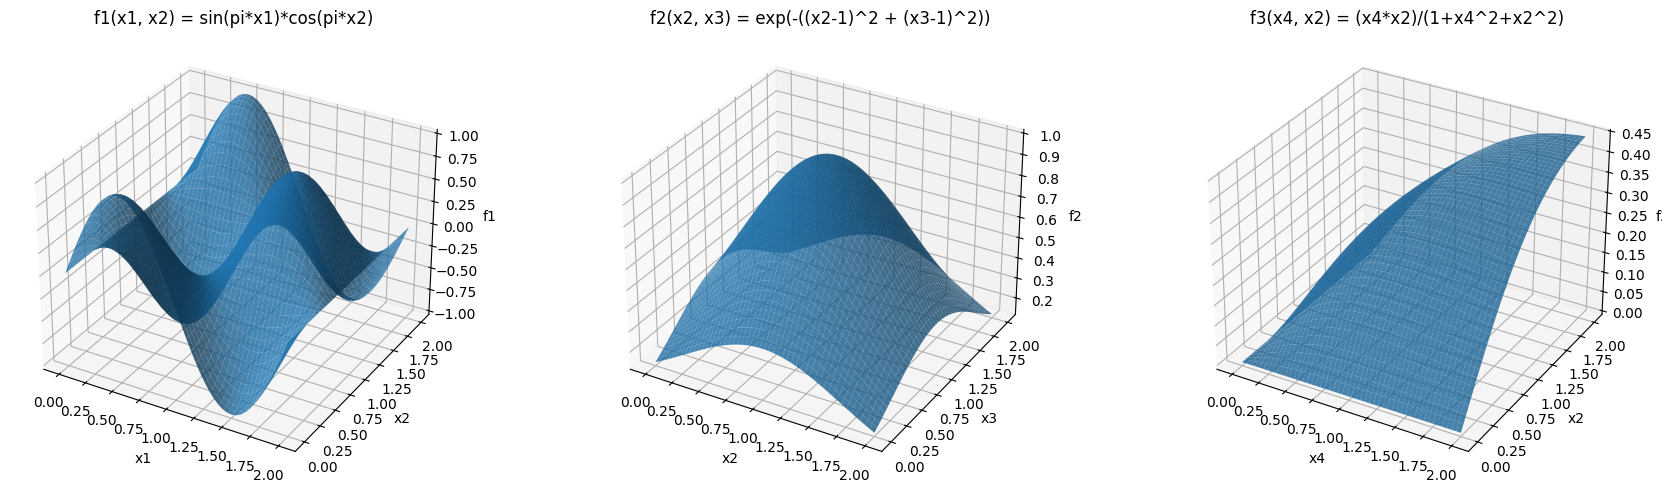

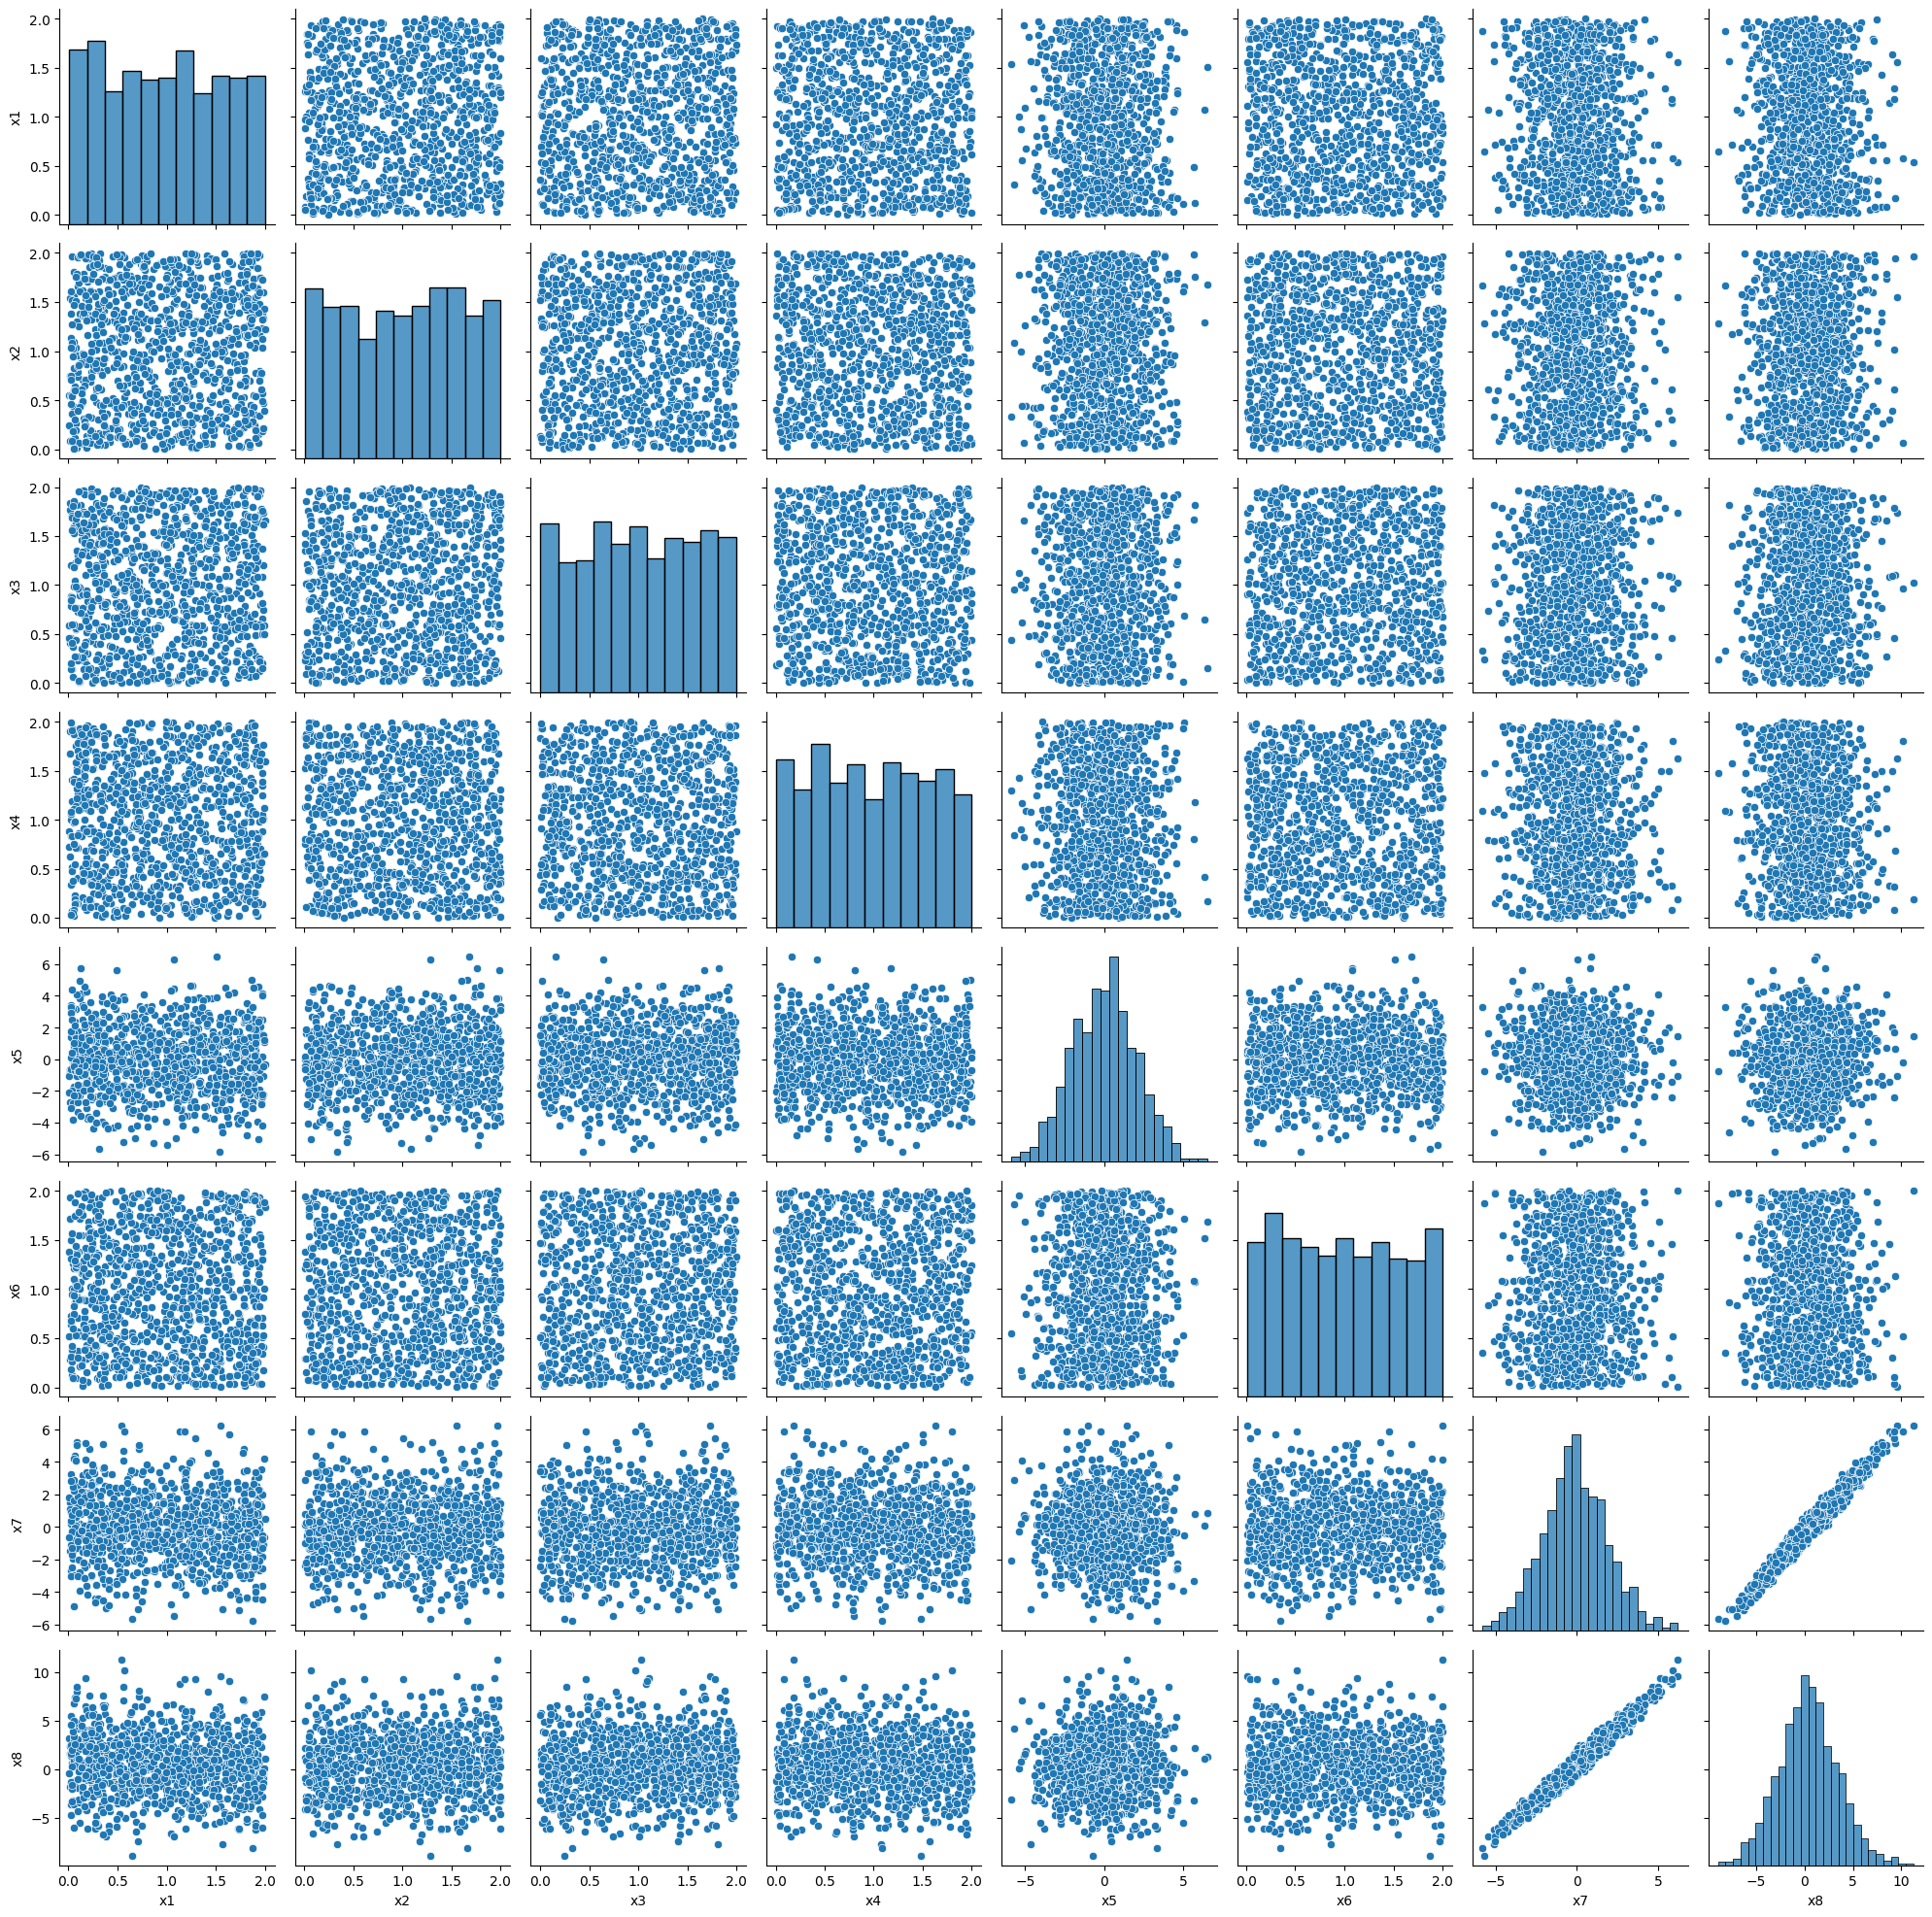

In [4]:

# Visualize the 3 interaction functions
fig = plt.figure(figsize=(18, 5))

# f1(x1, x2)
ax = fig.add_subplot(131, projection='3d')
x = np.linspace(0, 2, 50)
y = np.linspace(0, 2, 50)
X, Y = np.meshgrid(x, y)
Z = f1(X, Y)
ax.plot_surface(X, Y, Z, alpha=0.8)
ax.set_title("f1(x1, x2) = sin(pi*x1)*cos(pi*x2)")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("f1")

# f2(x2, x3)
ax = fig.add_subplot(132, projection='3d')
X, Y = np.meshgrid(x, y)
Z = f2(X, Y)
ax.plot_surface(X, Y, Z, alpha=0.8)
ax.set_title("f2(x2, x3) = exp(-((x2-1)^2 + (x3-1)^2))")
ax.set_xlabel("x2")
ax.set_ylabel("x3")
ax.set_zlabel("f2")

# f3(x4, x2)
ax = fig.add_subplot(133, projection='3d')
X, Y = np.meshgrid(x, y)
Z = f3(X, Y)
ax.plot_surface(X, Y, Z, alpha=0.8)
ax.set_title("f3(x4, x2) = (x4*x2)/(1+x4^2+x2^2)")
ax.set_xlabel("x4")
ax.set_ylabel("x2")
ax.set_zlabel("f3")

plt.tight_layout()
plt.show()


sns.pairplot(df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()

## 2.1 train test split

In [5]:
# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# 2. Compute quantiles from training data
quantiles = train_df.quantile([0.05, 0.95])
min_vals = quantiles.loc[0.05]
max_vals = quantiles.loc[0.95]

# 3. Normalize all sets using training quantiles
# def normalize_with_quantiles(df, min_vals, max_vals):
#     return (df - min_vals) / (max_vals - min_vals)

# train_df = normalize_with_quantiles(train_df, min_vals, max_vals)
# val_df = normalize_with_quantiles(val_df, min_vals, max_vals)
# test_df = normalize_with_quantiles(test_df, min_vals, max_vals)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 800, Validation size: 100, Test size: 100


# 3. Define graph Structure

- define graph and which shift and intercept terms to use


In [6]:
interactive_adj_matrix(CONF_DICT_PATH,seed=10) # TODO write from -> to 

No matrix found. Please fill out the DAG and click 'Generate'.


# 4. Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

In [7]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

*************
 Model has Complex intercepts and Complex shifts, please add your Model to the modelzoo 
*************


In [9]:
write_nodes_information_to_configuration_v3(CONF_DICT_PATH, min_vals, max_vals)

{'x1': {'Modelnr': 0, 'data_type': 'continous', 'node_type': 'source', 'parents': [], 'parents_datatype': {}, 'transformation_terms_in_h()': {}, 'min': 0.10363289207947189, 'max': 1.8947268989877823, 'transformation_term_nn_models_in_h()': {}}, 'x2': {'Modelnr': 1, 'data_type': 'continous', 'node_type': 'source', 'parents': [], 'parents_datatype': {}, 'transformation_terms_in_h()': {}, 'min': 0.09617707721630775, 'max': 1.9152953885721604, 'transformation_term_nn_models_in_h()': {}}, 'x3': {'Modelnr': 2, 'data_type': 'continous', 'node_type': 'source', 'parents': [], 'parents_datatype': {}, 'transformation_terms_in_h()': {}, 'min': 0.10217982588638876, 'max': 1.9121695544111015, 'transformation_term_nn_models_in_h()': {}}, 'x4': {'Modelnr': 3, 'data_type': 'continous', 'node_type': 'source', 'parents': [], 'parents_datatype': {}, 'transformation_terms_in_h()': {}, 'min': 0.10121765000817616, 'max': 1.87272970393435, 'transformation_term_nn_models_in_h()': {}}, 'x5': {'Modelnr': 4, 'dat

In [12]:
DEV_TRAINING=True
train_list=['x1','x2','x3','x4','x5','x6','x7','x8']#['x2']#'x1','x2']#,'x3']#['x1']#['x1','x2','x3']#,#,['x1','x2','x3'] # <-  set the nodes which have to be trained , useful if further training is required else lsit all vars

batch_size = 512#4112
epochs = 2# <- if you want a higher numbe rof epochs, set the number higher and it loads the old model and starts from there
learning_rate=0.01
use_scheduler =  False

In [ ]:
# def check_if_training_complete(node, NODE_DIR, epochs):
#     """
#     Check if the training for the given node is complete.
#     Returns True if training is complete, False otherwise.
#     """
#     MODEL_PATH, _, TRAIN_HIST_PATH, VAL_HIST_PATH = model_train_val_paths(NODE_DIR)
#     try:
#         if os.path.exists(MODEL_PATH) and os.path.exists(TRAIN_HIST_PATH) and os.path.exists(VAL_HIST_PATH):
#             with open(TRAIN_HIST_PATH, 'r') as f:
#                 train_loss_hist = json.load(f)

#             start_epoch = len(train_loss_hist)
            
#             # return false if already trained to skip to the next node 
#             if start_epoch >= epochs:
#                 print(f"Node {node} already trained for {epochs} epochs. Skipping.")
#                 return False
#             else:
#                 print(f"Node {node} not trained yet or training incomplete. Starting from epoch {start_epoch}.")
#                 return True
#         else:
            
#             return True
        
#     except Exception as e:
#         print(f"Error checking training status for node {node}: {e}")
#         return False

In [15]:
# For each NODE 
configuration_dict = load_configuration_dict(CONF_DICT_PATH)
target_nodes = configuration_dict['nodes']


for node in target_nodes:
    
    print(f'\n----*----------*-------------*--------------- Node: {node} ------------*-----------------*-------------------*--')
    ########################## 0. Skip nodes ###############################
    if node not in train_list:# Skip if node is not in train_list
        print(f"Skipping node {node} as it's not in the training list.")
        continue
    if (target_nodes[node]['node_type'] == 'source') and (target_nodes[node]['node_type'] == 'other'):# Skip unsupported types
        print(f"Node type : other , is not supported yet")
        continue

    ########################## 1. Setup Paths ###############################
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    os.makedirs(NODE_DIR, exist_ok=True)
    
    # Check if training is complete
    if not check_if_training_complete(node, NODE_DIR, epochs):
        continue
    
    
    ########################## 2. Create Model ##############################
    tram_model= get_fully_specified_tram_model_v5(node, target_nodes, verbose=True)

    
    ########################## 3. Create Dataloaders ########################
    train_loader, val_loader = get_dataloader_v5(node, target_nodes, train_df, val_df, batch_size=batch_size,return_intercept_shift=True, verbose=False)

    ########################## 5. Optimizer & Scheduler ######################.
    
    optimizer =torch.optim.Adam(tram_model.parameters(), lr=learning_rate)
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    else:
        scheduler = None

    ########################## 7. Training Loop ##############################
    
        train_val_loop_v5(
                   node,
                   target_nodes,
                   NODE_DIR,
                   tram_model,
                   train_loader,
                   val_loader,
                   epochs,
                   optimizer,
                   use_scheduler,
                   scheduler,
                   save_linear_shifts=False,
                   verbose=1,
                   device=device)
    


----*----------*-------------*--------------- Node: x1 ------------*-----------------*-------------------*--
Node x1 already trained for 2 epochs. Skipping.

----*----------*-------------*--------------- Node: x2 ------------*-----------------*-------------------*--
No existing model found. Starting fresh...


Saved new best model.
Epoch 1/2  Train Loss: 2.4055  Val Loss: 2.4022  [Train: 0.34s  Val: 0.24s  Total: 0.59s]
Saved new best model.
Epoch 2/2  Train Loss: 2.3855  Val Loss: 2.3882  [Train: 0.33s  Val: 0.26s  Total: 0.60s]

----*----------*-------------*--------------- Node: x3 ------------*-----------------*-------------------*--
No existing model found. Starting fresh...
Saved new best model.
Epoch 1/2  Train Loss: 2.3935  Val Loss: 2.4151  [Train: 0.33s  Val: 0.25s  Total: 0.58s]
Saved new best model.
Epoch 2/2  Train Loss: 2.3793  Val Loss: 2.4013  [Train: 0.33s  Val: 0.25s  Total: 0.59s]

----*----------*-------------*--------------- Node: x4 ------------*-----------------*-------------------*--
No existing model found. Starting fresh...
Saved new best model.
Epoch 1/2  Train Loss: 2.2640  Val Loss: 2.2567  [Train: 0.34s  Val: 0.24s  Total: 0.58s]
Saved new best model.
Epoch 2/2  Train Loss: 2.2476  Val Loss: 2.2437  [Train: 0.33s  Val: 0.25s  Total: 0.58s]

----*----------*-----

# 6 Inspect Training

## 6.1 Loss vs epochs

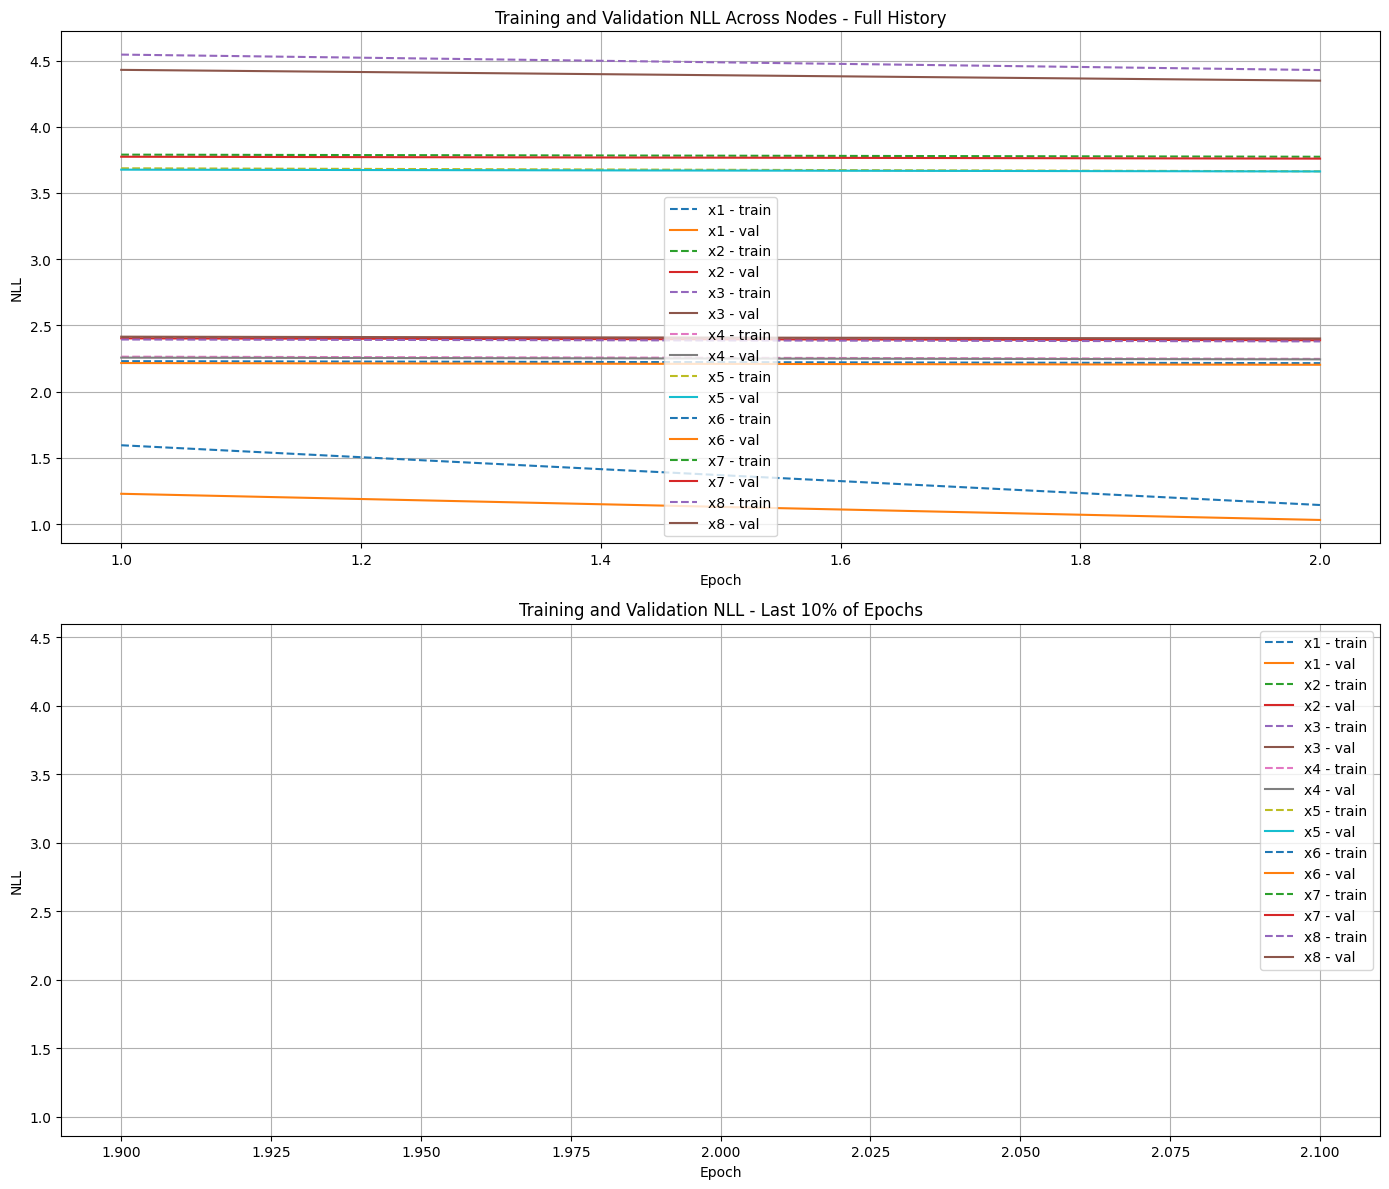

In [16]:
show_training_history(target_nodes,EXPERIMENT_DIR)

## 6.2 inspect transformation function for source nodes h()


----*----------*-------------*--------Inspect TRAFO Node: x1 ------------*-----------------*-------------------*--


h() for  x1:   0%|          | 0/1000 [00:00<?, ?it/s]


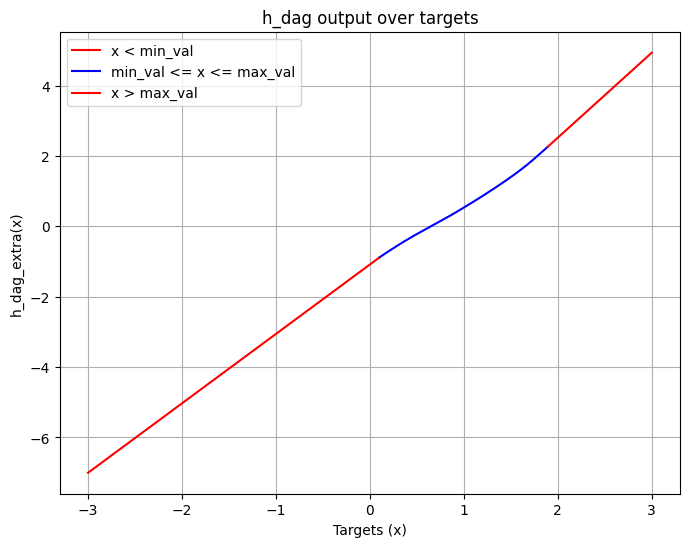


----*----------*-------------*--------Inspect TRAFO Node: x2 ------------*-----------------*-------------------*--


h() for  x2:   0%|          | 0/1000 [00:00<?, ?it/s]


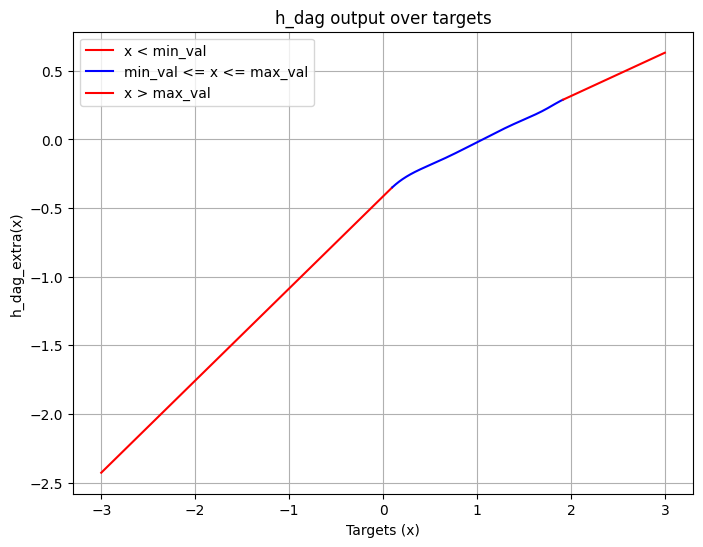


----*----------*-------------*--------Inspect TRAFO Node: x3 ------------*-----------------*-------------------*--


h() for  x3:   0%|          | 0/1000 [00:00<?, ?it/s]


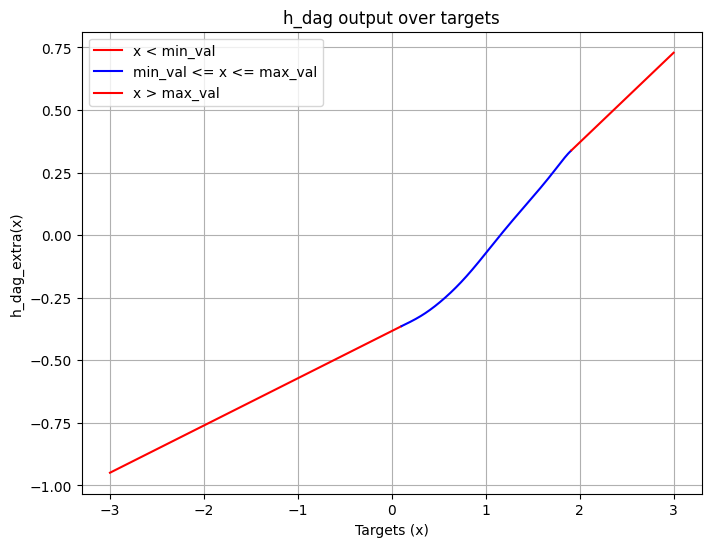


----*----------*-------------*--------Inspect TRAFO Node: x4 ------------*-----------------*-------------------*--


h() for  x4:   0%|          | 0/1000 [00:00<?, ?it/s]


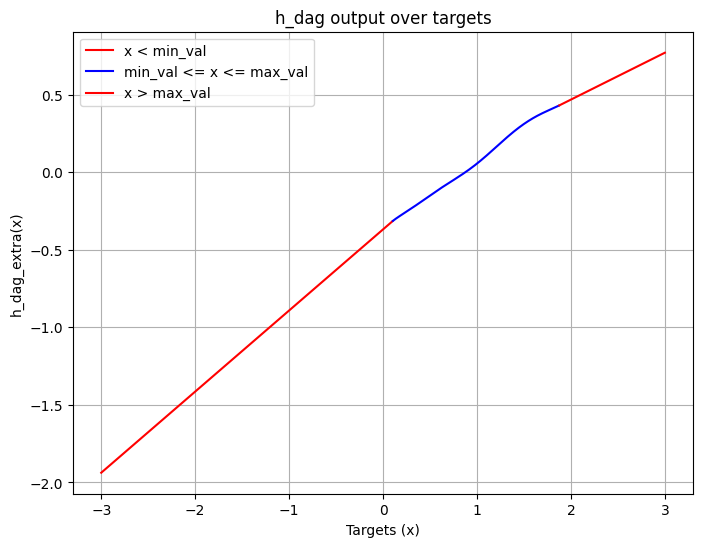


----*----------*-------------*--------Inspect TRAFO Node: x5 ------------*-----------------*-------------------*--


h() for  x5:   0%|          | 0/1000 [00:00<?, ?it/s]


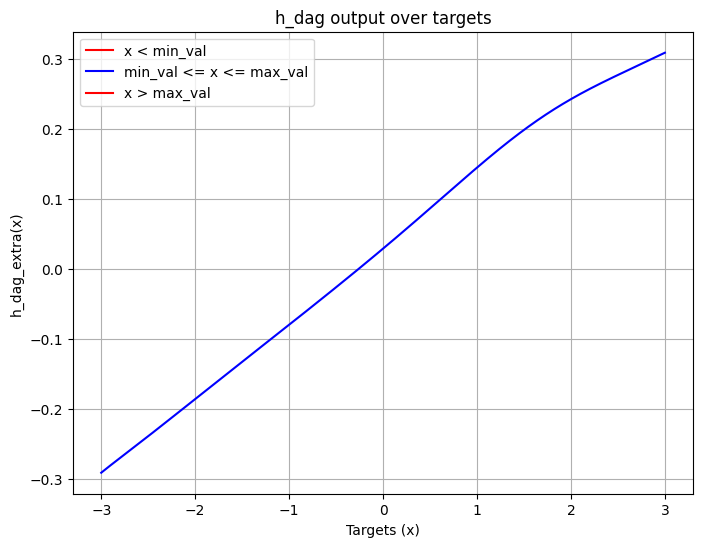


----*----------*-------------*--------Inspect TRAFO Node: x6 ------------*-----------------*-------------------*--


h() for  x6:   0%|          | 0/1000 [00:00<?, ?it/s]


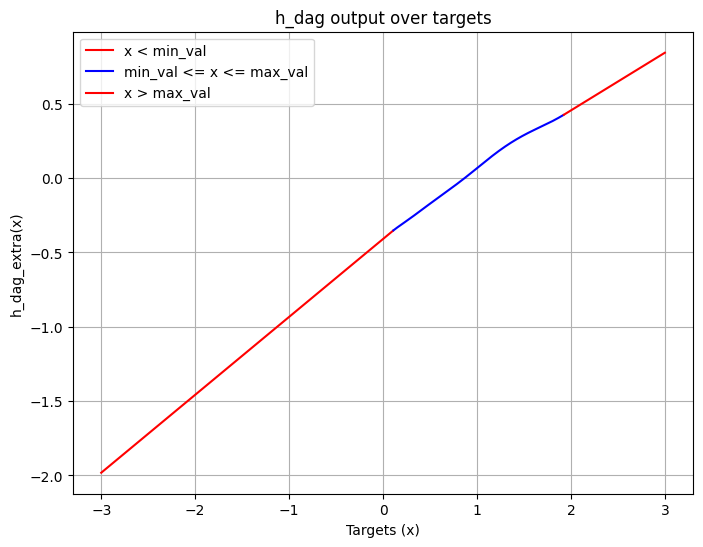


----*----------*-------------*--------Inspect TRAFO Node: x7 ------------*-----------------*-------------------*--


h() for  x7:   0%|          | 0/1000 [00:00<?, ?it/s]


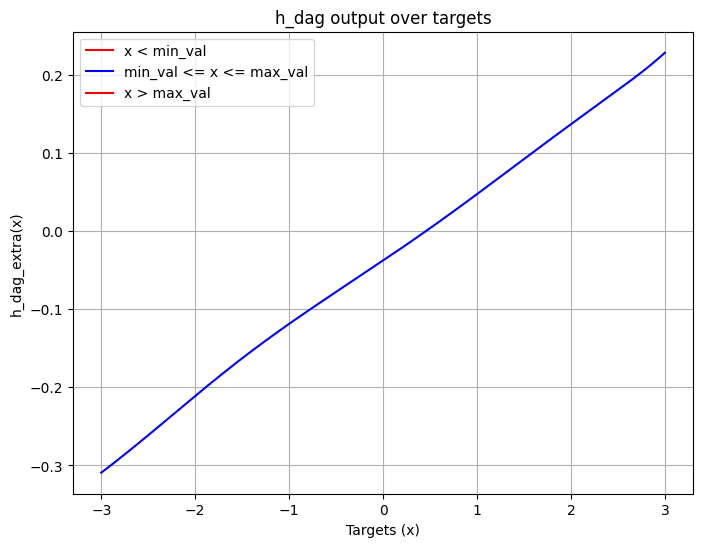


----*----------*-------------*--------Inspect TRAFO Node: x8 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance


In [17]:
show_hdag_for_source_nodes_v3(target_nodes,EXPERIMENT_DIR,device,xmin_plot=-3,xmax_plot=3)

----*----------*-------------*--------h(data) should be standard logistic: x1 ------------*-----------------*-------------------*--


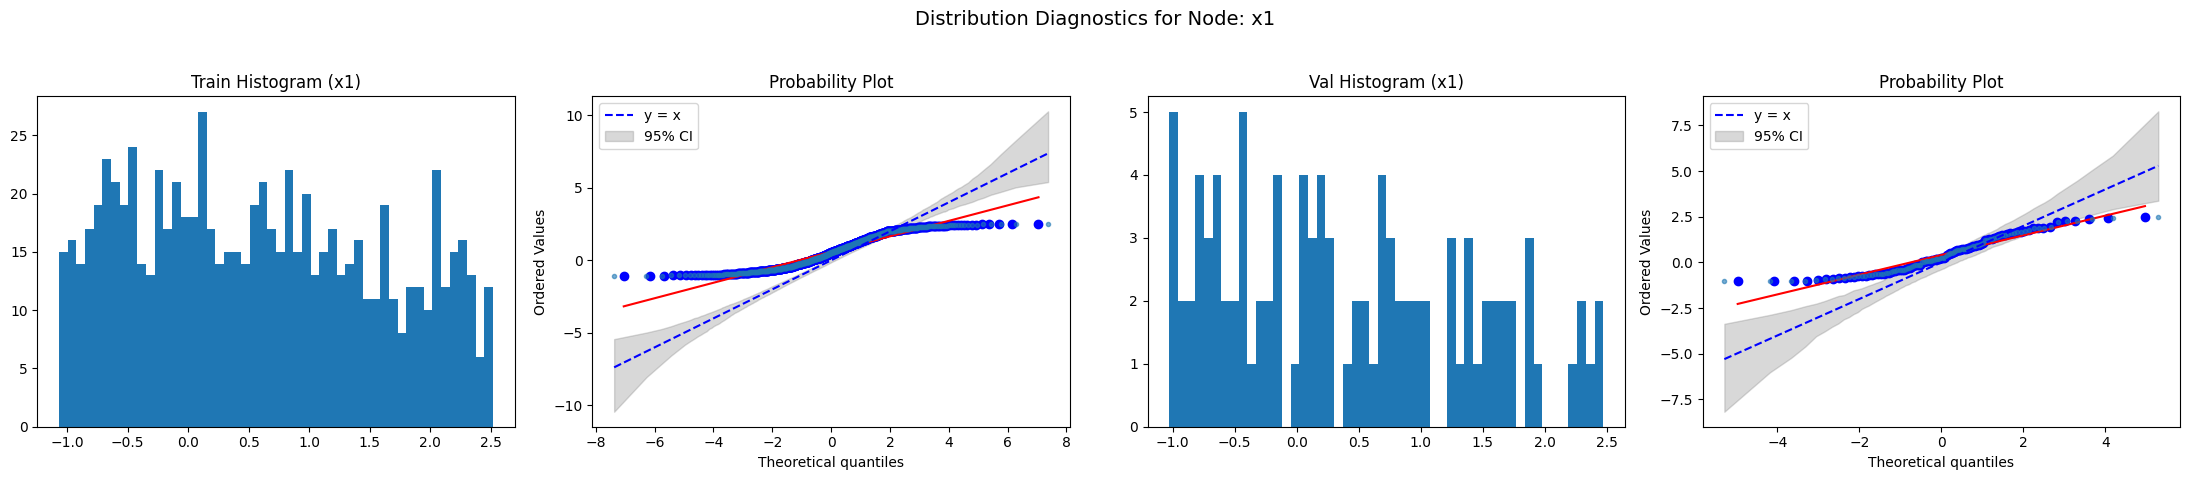

----*----------*-------------*--------h(data) should be standard logistic: x2 ------------*-----------------*-------------------*--


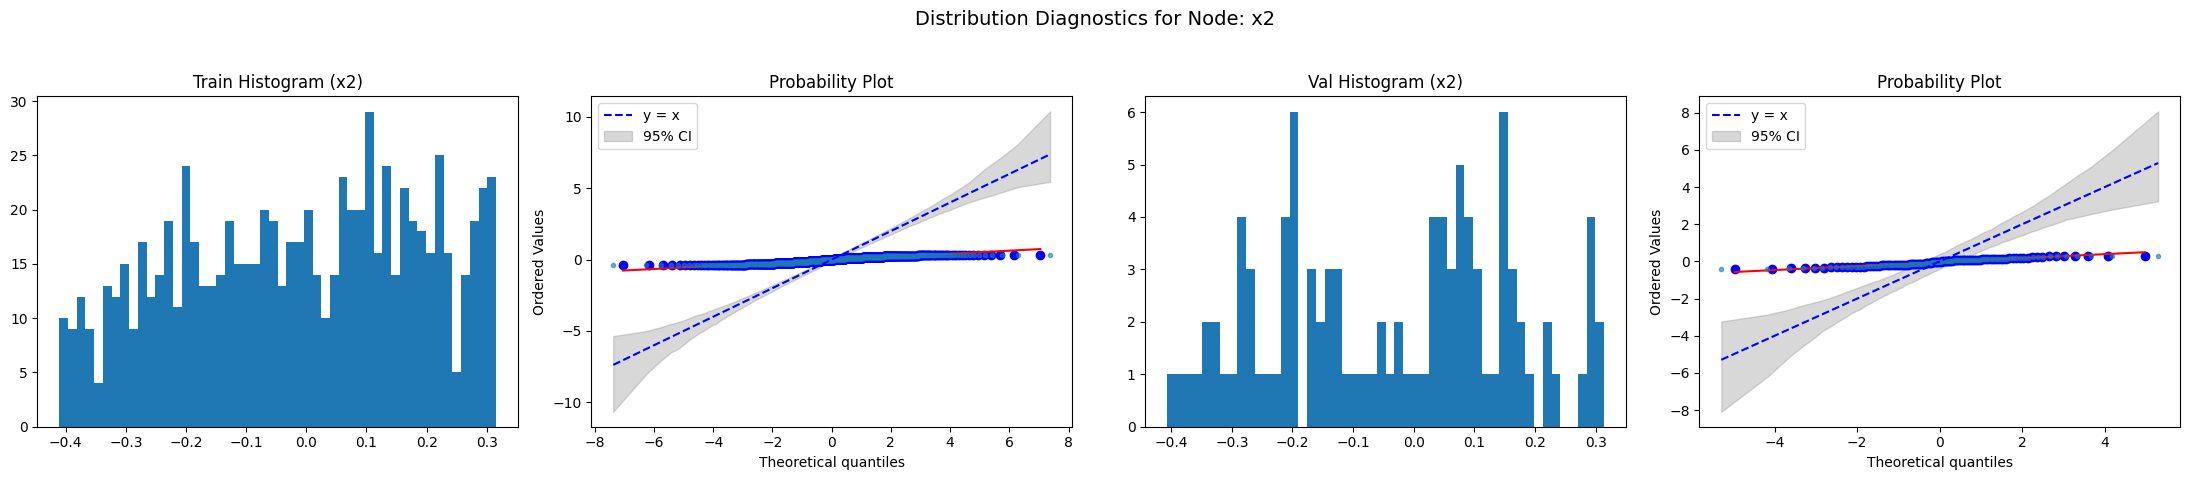

----*----------*-------------*--------h(data) should be standard logistic: x3 ------------*-----------------*-------------------*--


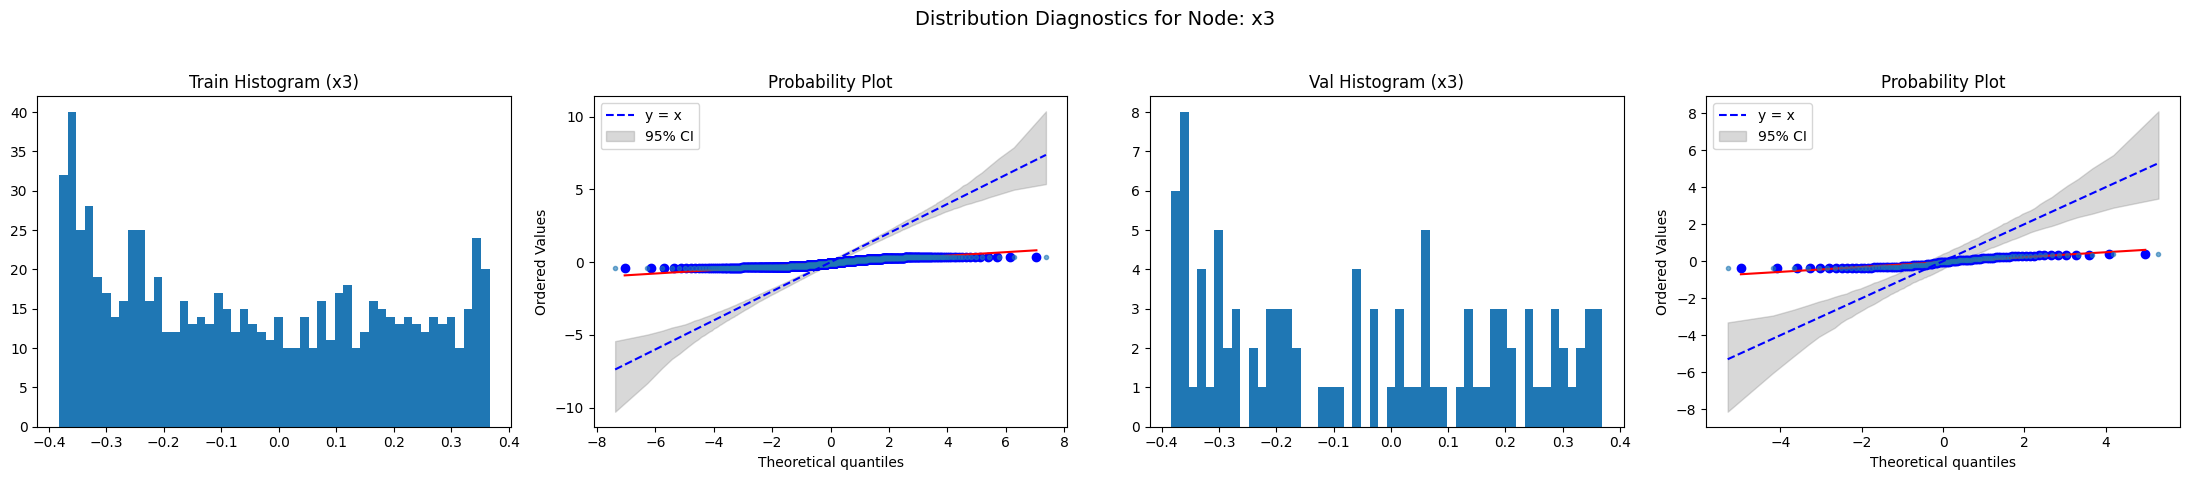

----*----------*-------------*--------h(data) should be standard logistic: x4 ------------*-----------------*-------------------*--


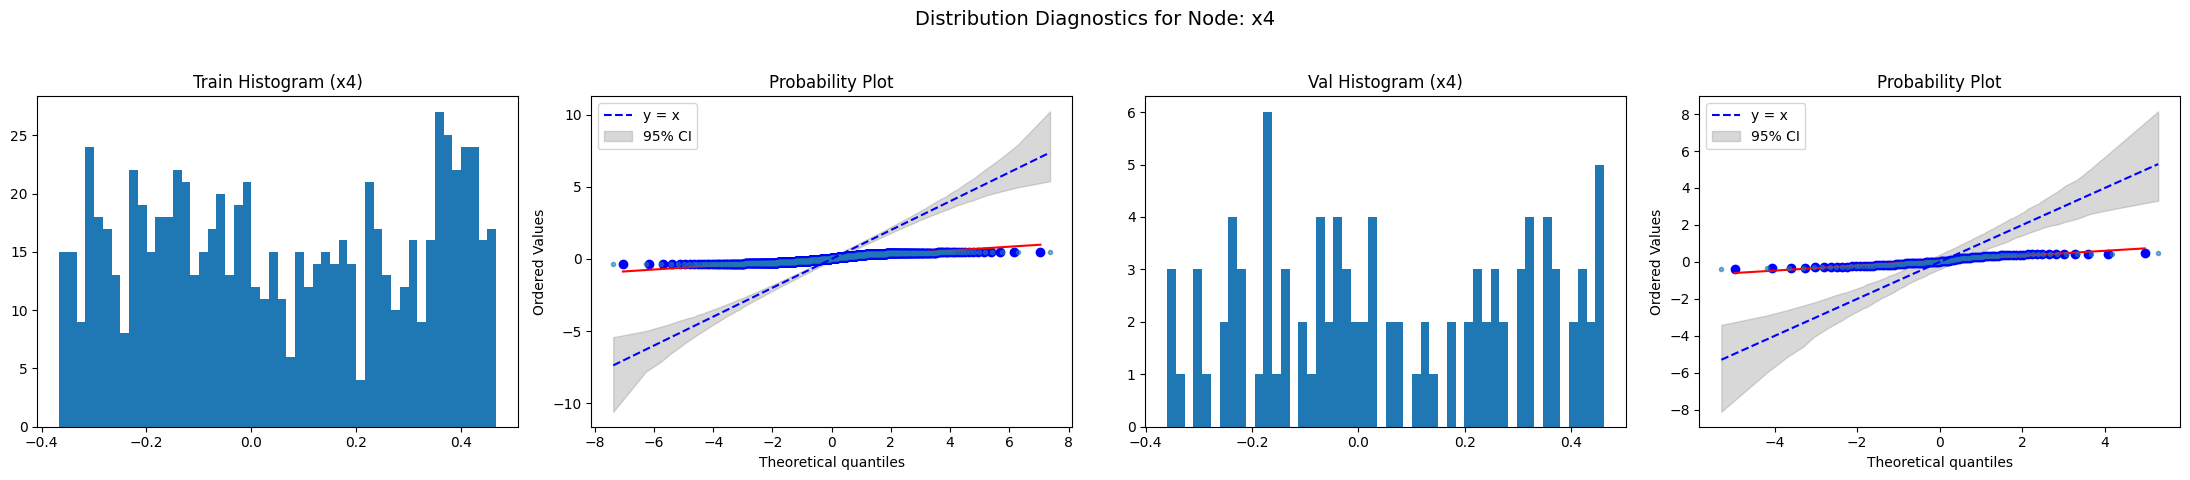

----*----------*-------------*--------h(data) should be standard logistic: x5 ------------*-----------------*-------------------*--


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x71f76444e790>
Traceback (most recent call last):
  File "/home/bule/anaconda3/envs/tramdag/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/bule/anaconda3/envs/tramdag/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  File "/home/bule/anaconda3/envs/tramdag/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/bule/anaconda3/envs/tramdag/lib/python3.9/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/home/bule/anaconda3/envs/tramdag/lib/python3.9/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/home/bule/ana

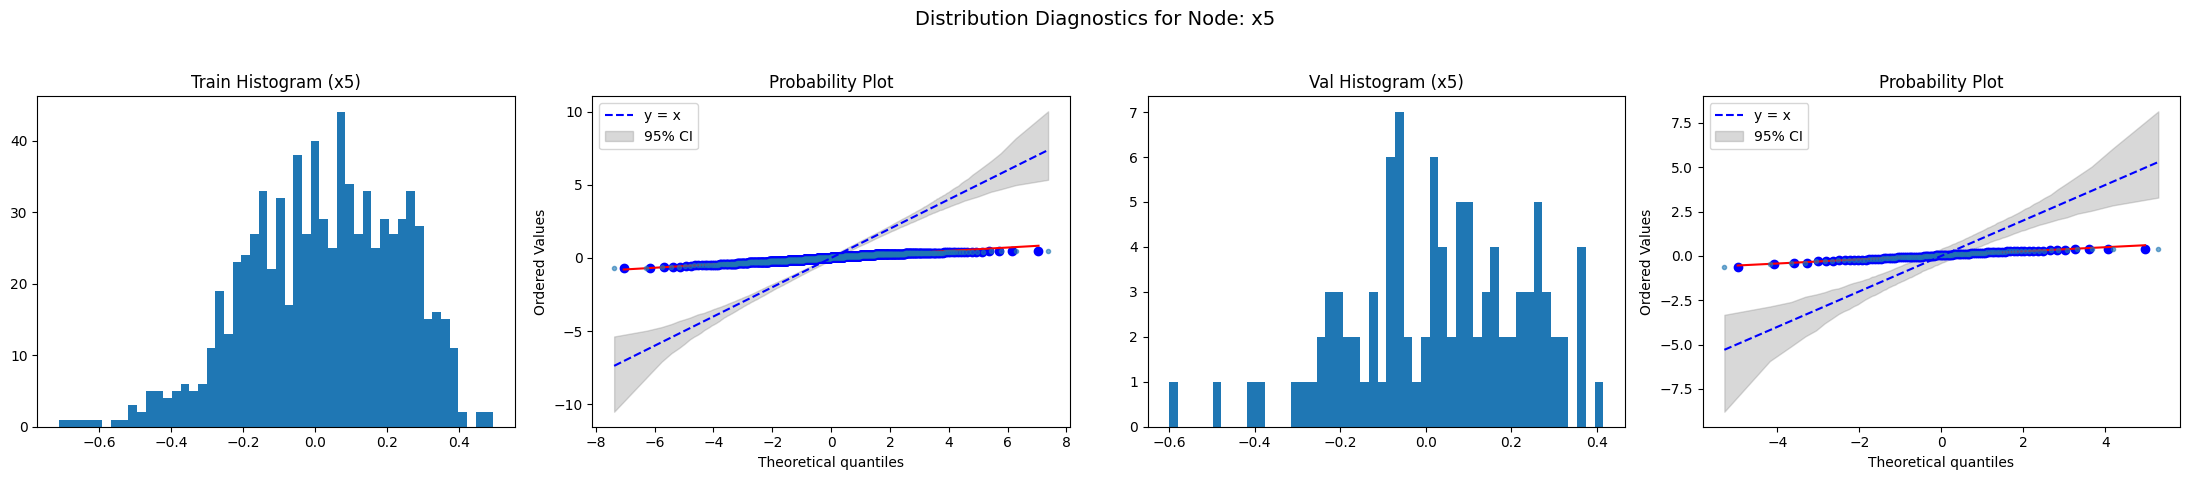

----*----------*-------------*--------h(data) should be standard logistic: x6 ------------*-----------------*-------------------*--


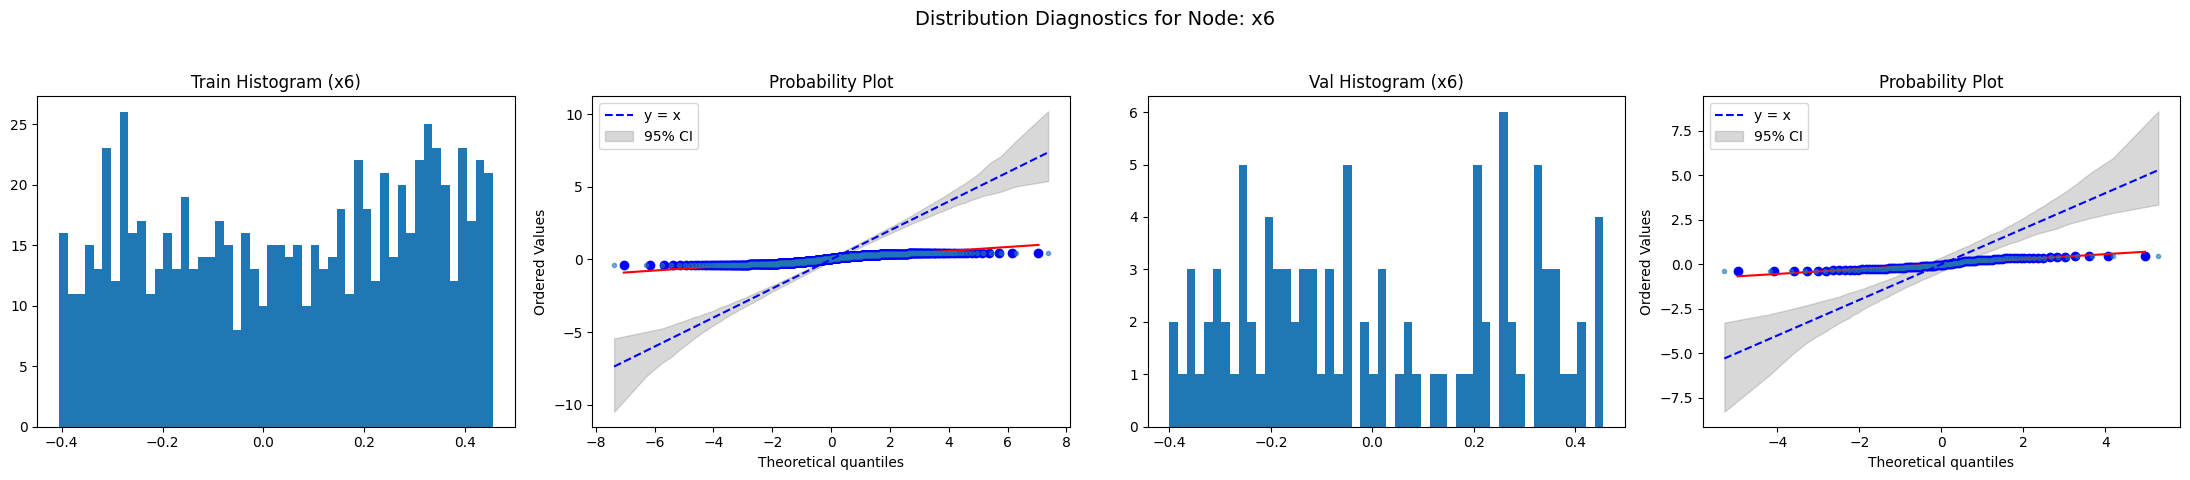

----*----------*-------------*--------h(data) should be standard logistic: x7 ------------*-----------------*-------------------*--


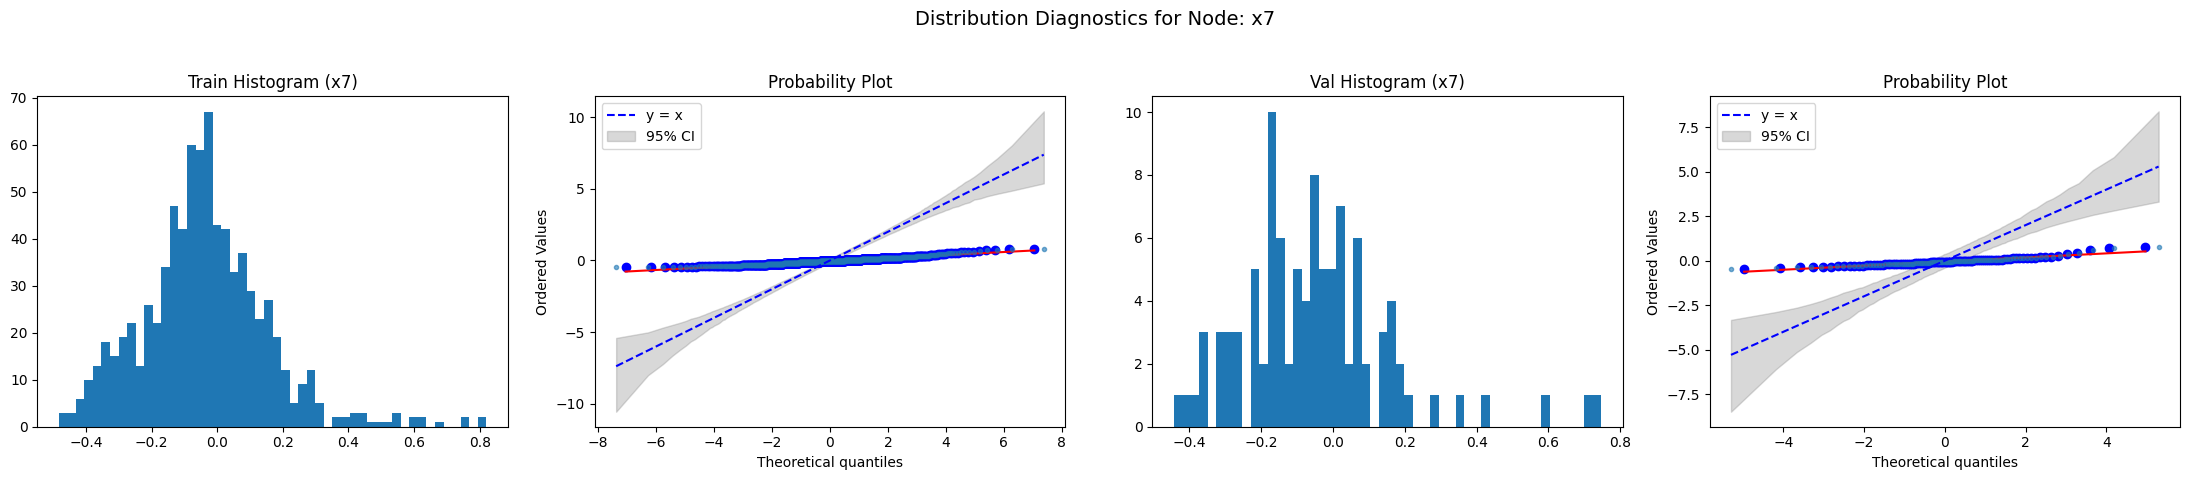

----*----------*-------------*--------h(data) should be standard logistic: x8 ------------*-----------------*-------------------*--


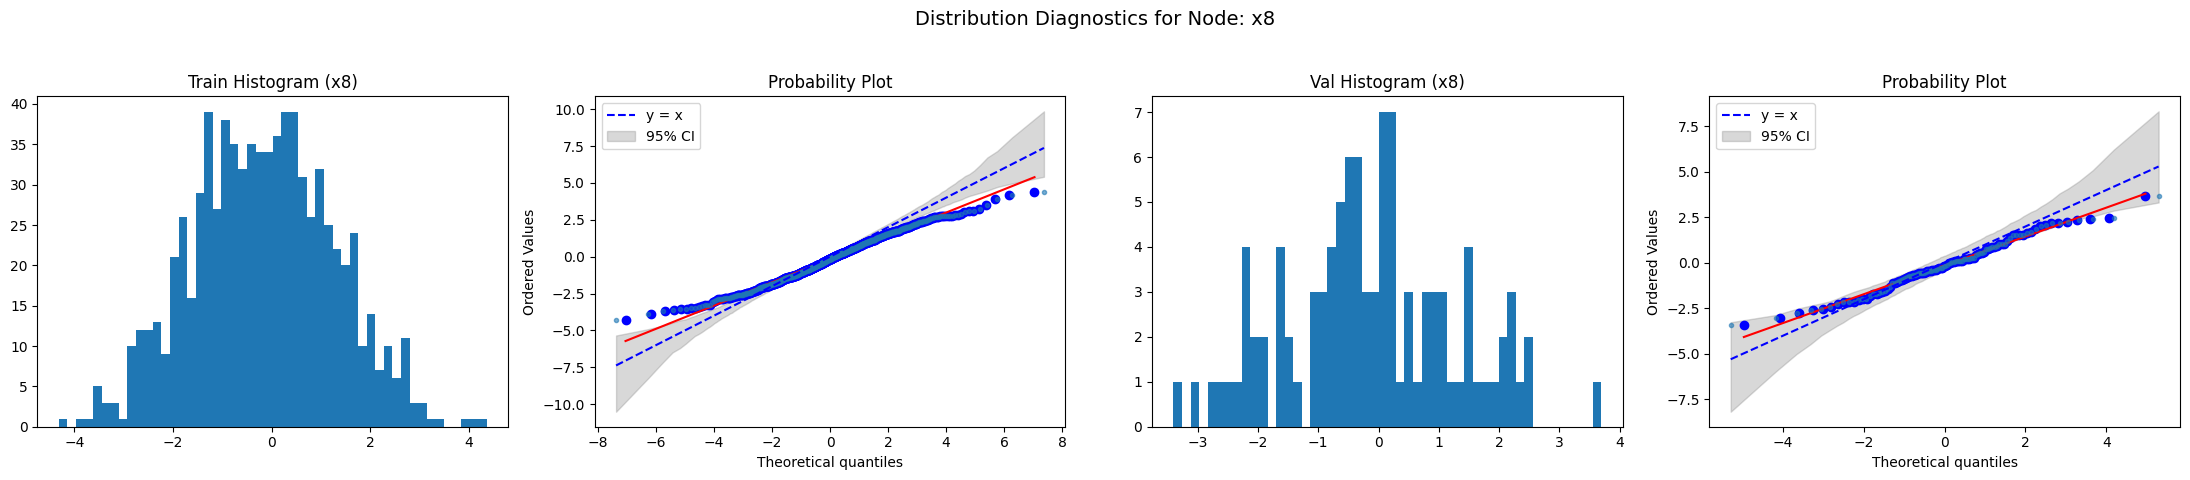

In [18]:
inspect_trafo_standart_logistic_v3(target_nodes, EXPERIMENT_DIR, train_df, val_df, device, verbose=False)


# 7. Sample from Graph

In [ ]:
def create_df_from_sampled(node,target_nodes_dict,SAMPLING_DIR):
    sampling_dict={}
    for parent in target_nodes_dict[node]['parents']:
        sampled=torch.load(os.path.join(SAMPLING_DIR,f"sampled.pt"))
        sampling_dict[parent]=sampled
    sampling_df=pd.DataFrame(sampling_dict)
    return sampling_df




def criteria_for_continous_modelled_outcome(node,target_nodes_dict):
    if 'yc'in target_nodes_dict[node]['data_type'].lower() or 'continous' in target_nodes_dict[node]['data_type'].lower():
        return True
    else:
        return False

def criteria_for_ordinal_modelled_outcome(node,target_nodes_dict):
    if 'yo'in target_nodes_dict[node]['data_type'].lower() and 'ordinal' in target_nodes_dict[node]['data_type'].lower():
        return True
    else:
        return False  
    
    
def sample_continous_modelled_target(node,target_nodes_dict,sample_loader,tram_model,latent_sample):
    
    _, ordered_transformation_terms_in_h, _=ordered_parents(node, target_nodes_dict)
    output_list = []
    with torch.no_grad():
        for x in tqdm(sample_loader, desc=f"h() for samples in  {node}"):
            # x = [xi.to(device) for xi in x]
            
            # print(f"x {x}")
            # int_input, shift_list = preprocess_inputs_v2(x,ordered_transformation_terms_in_h.values(), device=device)
            
        
            if int_input is not None:
                print(f"int_input {int_input.shape}")
            if shift_list is not None:
                print(f"shift_list {[s.shape for s in shift_list]}") 
            
            print([t.shape for t in x])
            
            model_outputs = tram_model(int_input=int_input, shift_input=shift_list)
            
            print(f"model_outputs {model_outputs}")
            
            output_list.append(model_outputs)
            
    if target_nodes_dict[node]['node_type'] == 'source':
        if verbose:
            print("source node, Defaults to SI and 1 as inputs")
        theta_single = output_list[0]['int_out'][0]
        theta_single = transform_intercepts_continous(theta_single)
        thetas_expanded = theta_single.repeat(n, 1)
        shifts = torch.zeros(n, device=device)
    else:
        if verbose:
            print("node has parents, previously sampled data is loaded for each pa(node)")
        y_pred = merge_outputs(output_list, skip_nan=True)
        shifts = y_pred['shift_out']
        if shifts is None:
            print("shift_out was None; defaulting to zeros.")
            shifts = torch.zeros(n, device=device)
        thetas = y_pred['int_out']
        thetas_expanded = transform_intercepts_continous(thetas).squeeze()
        shifts = shifts.squeeze()
    
    low = torch.full((n,), -1e5, device=device)
    high = torch.full((n,), 1e5, device=device)
    min_vals = torch.tensor(target_nodes_dict[node]['min'], dtype=torch.float32).to(device)
    max_vals = torch.tensor(target_nodes_dict[node]['max'], dtype=torch.float32).to(device)
    min_max = torch.stack([min_vals, max_vals], dim=0)
    
    ## Root finder using Chandrupatla's method
    def f_vectorized(targets):
        return vectorized_object_function(
            thetas_expanded,
            targets,
            shifts,
            latent_sample,
            k_min=min_max[0],
            k_max=min_max[1]
        )
        
    sampled = chandrupatla_root_finder(
        f_vectorized,
        low,
        high,
        max_iter=10_000,
        tol=1e-9
    )
    return sampled
    
    
    
def sample_ordinal_modelled_target(node,target_nodes_dict,sample_loader,tram_model):
    print('not implemented yet')
    
    
def sample_full_dag_chandru_v2(target_nodes_dict,
                            EXPERIMENT_DIR,
                            device,
                            do_interventions={},
                            n= 10_000,
                            batch_size = 32,
                            delete_all_previously_sampled=True,
                            verbose=True):
    """
    Samples data for all nodes in a DAG defined by `conf_dict`, ensuring that each node's
    parents are sampled before the node itself. Supports interventions on any subset of nodes.

    Parameters
    ----------
    conf_dict : dict
        Dictionary defining the DAG. Each key is a node name, and each value is a config
        dict that includes at least:
            - 'node_type': str, either 'source' or other
            - 'parents': list of parent node names
            - 'min': float, minimum allowed value for the node
            - 'max': float, maximum allowed value for the node

    EXPERIMENT_DIR : str
        Base directory where all per-node directories are located.

    device : torch.device
        The device to run computations on (e.g., 'cuda' or 'cpu').

    do_interventions : dict, optional
        A dictionary specifying interventions for some nodes. Keys are node names (str),
        values are floats. For each intervened node, the specified value is used as the
        sampled value for all samples, and the model is bypassed. e.g. {'x1':1.0}

    n : int, optional
        Number of samples to draw for each node (default is 10_000).

    batch_size : int, optional
        Batch size for model evaluation during sampling (default is 32).

    delete_all_previously_sampled : bool, optional
        If True, removes previously sampled data before starting (default is True).

    verbose : bool, optional
        If True, prints debug/status information (default is True).

    Notes
    -----
    - The function ensures that nodes are only sampled after their parents.
    - Nodes with `node_type='source'` are treated as having no parents.
    - If a node is in `do_interventions`, `sampled_chandrupatla.pt` and a dummy `latents.pt`
      are created, enabling downstream nodes to proceed.
    - Sampling is done using a vectorized root-finding method (Chandrupatla's algorithm).
    """


    # delete the previolusly sampled data
    if delete_all_previously_sampled:
        delete_all_samplings(target_nodes_dict, EXPERIMENT_DIR)
    
    
    # repeat process until all nodes are sampled
    processed_nodes=[] # log the processed nodes in this list
    while set(processed_nodes) != set(target_nodes_dict.keys()): 
        for node in target_nodes_dict: # for each node in the target_nodes_dict
            if node in processed_nodes:
                if verbose :
                    print('node is already  in sampled list')
                continue
                        
            print(f'\n----*----------*-------------*--------Sample Node: {node} ------------*-----------------*-------------------*--') 
            
            ## 1. Paths 
            NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
            SAMPLING_DIR = os.path.join(NODE_DIR, 'sampling')
            os.makedirs(SAMPLING_DIR, exist_ok=True)
            SAMPLED_PATH = os.path.join(SAMPLING_DIR, "sampled_chandrupatla.pt")
            LATENTS_PATH = os.path.join(SAMPLING_DIR, "latents.pt")
            
            
            ## 2. Check if sampled and latents already exist 
            if check_sampled_and_latents(NODE_DIR, rootfinder='chandrupatla', verbose=verbose):
                processed_nodes.append(node)
                continue
            
            ## 3. logic to make sure parents are always sampled first
            skipping_node = False
            if target_nodes_dict[node]['node_type'] != 'source':
                for parent in target_nodes_dict[node]['parents']:
                    if not check_sampled_and_latents(os.path.join(EXPERIMENT_DIR, parent), rootfinder='chandrupatla', verbose=verbose):
                        skipping_node = True
                        break
                    
            if skipping_node:
                print(f"Skipping {node} as parent {parent} is not sampled yet.")
                continue
            
            
            ## INTERVENTION, if node is to be intervened on , data is just saved
            if do_interventions and node in do_interventions.keys():
                    # For interventions make all the values the same for 
                    intervention_value = do_interventions[node]
                    intervention_vals = torch.full((n,), intervention_value)
                    torch.save(intervention_vals, SAMPLED_PATH)
                    
                    ### dummy latents jsut for the check , not needed
                    dummy_latents = torch.full((n,), float('nan'))  
                    torch.save(dummy_latents, LATENTS_PATH)
                    processed_nodes.append(node)
                    print(f'Interventional data for node {node} is saved')
                    continue
                
            ##### %%%%%%% no intervention, based on the sampled data from the parents though the latents for each node the observational distribution is generated    
            else:
                ### sampling latents
                latent_sample = torch.tensor(logistic.rvs(size=n), dtype=torch.float32).to(device)
                
                ### load modelweights
                MODEL_PATH = os.path.join(NODE_DIR, "best_model.pt")
                tram_model = get_fully_specified_tram_model_v5(node, target_nodes, verbose=True).to(device)
                tram_model.load_state_dict(torch.load(MODEL_PATH))

                
                
                # isntead of sample loader use Generic Dataset but the df is just to sampled data from befor -> create df on the fly
                sampled_df=create_df_from_sampled(node,target_nodes_dict,SAMPLING_DIR)
                
    
                transform = transforms.Compose([
                    transforms.Resize((128, 128)),
                    transforms.ToTensor()
                ])

                ordered_parents_dataype_dict, ordered_transformation_terms_in_h, _ = ordered_parents(node, target_nodes)
                    
                sample_dataset = GenericDataset_v5(sampled_df,target_col=node,
                                                   target_nodes=target_nodes,
                                                   parents_dataype_dict=ordered_parents_dataype_dict,
                                                   transform=transform,transformation_terms_in_h=ordered_transformation_terms_in_h,
                                                   return_intercept_shift=return_intercept_shift,
                                                   return_y=False)
                
                sample_loader = DataLoader(sample_dataset, batch_size=batch_size, shuffle=True,num_workers=4, pin_memory=True)
                
                
                
                # # dataset = SamplingDataset(node=node, EXPERIMENT_DIR=EXPERIMENT_DIR, rootfinder='chandrupatla', number_of_samples=n, target_nodes=target_nodes_dict, transform=None)
                # sample_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
                
                
                ###*************************************************** Continous Modelled Outcome ************************************************
                
                if criteria_for_continous_modelled_outcome(node,target_nodes_dict):
                    sampled=sample_continous_modelled_target(node,target_nodes_dict,sample_loader,tram_model,latent_sample)
                    
                ###*************************************************** Ordinal Modelled Outcome ************************************************
                
                if criteria_for_ordinal_modelled_outcome(node,target_nodes_dict):
                    sampled=sample_ordinal_modelled_target(node,target_nodes_dict,sample_loader,tram_model)
                
                else:
                    raise ValueError(f"Unsupported data_type '{target_nodes_dict[node]['data_type']}' for node '{node}' in sampling.")
                    
                    
                ###*************************************************** Saving the latenst and sampled  ************************************************
                if torch.isnan(sampled).any():
                    print(f'Caution! Sampling for {node} consists of NaNs')
                    
                torch.save(sampled, SAMPLED_PATH)
                torch.save(latent_sample, LATENTS_PATH)
                
                processed_nodes.append(node)
                
                    

## 7.3 Inspect Sampling

In [ ]:
show_samples_vs_true(test_df,target_nodes,EXPERIMENT_DIR,rootfinder='chandrupatla')

## 7.4 Intervention

In [ ]:
def f(x):
    return -0.3*x  

intervention_df=dgp(10_000, doX=[-1.0, None, None], seed=-1)
sns.pairplot(intervention_df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
sample_full_dag_chandru(target_nodes,
                            EXPERIMENT_DIR,
                            device,
                            do_interventions={'x1':-1.0},
                            n= 10_000,
                            batch_size = 32,
                            delete_all_previously_sampled=True,
                            verbose=True)

In [ ]:
show_samples_vs_true(intervention_df,target_nodes,EXPERIMENT_DIR,rootfinder='chandrupatla')